In [2]:
from exojax.spec.tau1height import get_P_at_tauone

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from exojax.spec.rtransfer import pressure_layer
from exojax.spec.setrt import gen_wavenumber_grid
from exojax.utils.instfunc import R2STD

from exojax.spec import moldb, molinfo
from exojax.spec import premodit, modit, initspec

from exojax.utils.afunc import getjov_gravity
from exojax.utils.grids import velocity_grid

from exojax.spec.rtransfer import  dtauM_mmwl, dtauHminus_mmwl, rtrun
from exojax.spec import planck, response, spin_rotation
from jax import vmap

HAPI version: 1.2.2.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

In [3]:
# Wavelength
wls, wll, Nx = 15020, 15030, 2000
nus, wav, reso = gen_wavenumber_grid(wls - 1., wll+ 1., Nx, unit="AA", xsmode="modit")

# Atmosphere (T-P)
Parr, dParr, k = pressure_layer(NP = 100)

# Instrumental 
Rinst=100000.
beta_inst=R2STD(Rinst)  
nusd = jnp.linspace(1e8/wll,  1e8/wls, 400)
wavd = 1e8/nusd[::-1]

# Reference pressure for a T-P model
Pref=1.0 #bar
ONEARR=np.ones_like(Parr)

# Set array for response before HMC                                                                   
vsini_max = 100.0
vr_array = velocity_grid(reso, vsini_max)

xsmode assumes ESLOG in wavenumber space: mode=modit


In [4]:
# Load line data

# H2O (PreMODIT)
molmassH2O = molinfo.molmass("H2O")
mdbH2O_orig = moldb.MdbExomol('.database/H2O/1H2-16O/POKAZATEL', nus, crit=0.0)
lbd_H2O, multi_index_uniqgrid_H2O, elower_grid_H2O, \
ngamma_ref_grid_H2O, n_Texp_grid_H2O, R_H2O, pmarray_H2O = initspec.init_premodit(
    mdbH2O_orig.nu_lines,
    nus,
    mdbH2O_orig.elower,
    mdbH2O_orig.alpha_ref,
    mdbH2O_orig.n_Texp,
    mdbH2O_orig.Sij0,
    Ttyp=3000,
    interval_contrast=0.1,
    dit_grid_resolution=0.1,
    warning=False)

# OH
molmassOH = molinfo.molmass("OH")
mdbOH = moldb.MdbExomol('.database/OH/16O-1H/MoLLIST', nus)
cnu_OH, indexnu_OH, R, pmarray = initspec.init_modit(mdbOH.nu_lines, nus)
# Precompute dgm_ngammaL
fT = lambda T0,alpha: T0[:,None]*(Parr[None,:]/Pref)**alpha[:,None]
T0_test = np.array([2000.0, 4000.0, 2000.0, 4000.0])
alpha_test = np.array([0.2,0.2,0.05,0.05])
res_test = 0.2
dgm_ngammaL_OH = modit.set_ditgrid_matrix_exomol(mdbOH, fT, Parr, R, molmassOH, res_test, T0_test, alpha_test)

Background atmosphere:  H2
Reading transition file
.broad is used.
Broadening code level= a1
default broadening parameters are used for  12  J lower states in  63  states


uniqidx: 100%|██████████████████████████████████| 26/26 [00:00<00:00, 69.42it/s]


Background atmosphere:  H2
Error: Couldn't download .broad file and save.
Error: Couldn't download .broad file and save.
Error: Couldn't download .broad file and save.
Reading transition file
.broad is used.


In [5]:
def frun(T0, alpha, Mp, Rp, u1, u2, RV, vsini, mmw, VMR_e, VMR_H, \
         VMR_H2O, VMR_OH, adjust_continuum1, adjust_continuum2):
    
    # Atmosphere and gravity
    Tarr = T0*(Parr)**alpha
    ga = getjov_gravity(Rp,Mp)
    
    # H2O (PreMODIT)
    qtarr = vmap(mdbH2O_orig.qr_interp)(Tarr)
    xsm_H2O = premodit.xsmatrix(Tarr, Parr, R_H2O, pmarray_H2O, lbd_H2O, nus, ngamma_ref_grid_H2O,
                   n_Texp_grid_H2O, multi_index_uniqgrid_H2O, elower_grid_H2O, molmassH2O, qtarr)
    dtaum_H2O = dtauM_mmwl(dParr, jnp.abs(xsm_H2O), VMR_H2O*ONEARR, mmw*ONEARR, ga) 
    P_tau1_H2O = get_P_at_tauone(dtaum_H2O, Parr)
    
    # OH (MODIT)
    SijM_OH, ngammaLM_OH, nsigmaDl_OH = modit.exomol(mdbOH, Tarr, Parr, R, molmassOH)
    xsm_OH = modit.xsmatrix(cnu_OH, indexnu_OH, R, pmarray, nsigmaDl_OH, ngammaLM_OH, SijM_OH, nus, dgm_ngammaL_OH)
    dtaum_OH = dtauM_mmwl(dParr, jnp.abs(xsm_OH), VMR_OH*ONEARR, mmw*ONEARR, ga) 
    P_tau1_OH = get_P_at_tauone(dtaum_OH, Parr) #, tauextracted=0.1)

    # Hminus continuum
    dtau_Hm = dtauHminus_mmwl(nus, Tarr, Parr, dParr, VMR_e*ONEARR, VMR_H*ONEARR, mmw*ONEARR, ga)
    P_tau1_Hm = get_P_at_tauone(dtau_Hm, Parr)
    
    # Total delta tau
    dtau = dtaum_H2O + dtaum_OH + dtau_Hm
    
    # Radiative transfer
    sourcef = planck.piBarr(Tarr, nus)
    F0 = rtrun(dtau, sourcef)
    Frot = spin_rotation.convolve_rigid_rotation(F0, vr_array, vsini, u1, u2)
    mu = response.ipgauss_sampling(nusd, nus, Frot, beta_inst, RV)
    a = (adjust_continuum1 - adjust_continuum2) / (wavd[0] - wavd[-1])
    b = adjust_continuum1 - a * wavd[0]
    f_adjust_continuum = lambda x: a*x + b
    mu_absmax = jnp.nanmax(mu)
    mu = mu/jnp.nanmax(mu) * f_adjust_continuum(wavd[::-1])
    
    list_P_tau1 = [P_tau1_H2O, P_tau1_OH, P_tau1_Hm]
    return(mu, list_P_tau1)

In [6]:
# Forward modeling

T0 = 3000
alpha = 0.1
Mp = 0.155 *1.99e33/1.90e30 # GJ699
Rp = 0.186 *6.96e10/6.99e9 # GJ699
u1= 0.0
u2 = 0.0
RV = 0.0
vsini = 2.0
mmw = 2.33 
VMR_e = 10**-5.67
VMR_H = 0.06
VMR_H2O = 10**-3.40
VMR_OH = 10**-4.30
adjust_continuum1 = 1.0
adjust_continuum2 = 1.0

mu, list_P_tau1 = frun(T0, alpha, Mp, Rp, u1, u2, RV, vsini, mmw, VMR_e, VMR_H, \
         VMR_H2O, VMR_OH, adjust_continuum1, adjust_continuum2) 

P_tau1_H2O, P_tau1_OH, P_tau1_Hm = list_P_tau1

/tmp/ipykernel_180197/3769097601.py:19: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(1e8/nus, np.log10(P_tau1_OH), '--', label="OH")


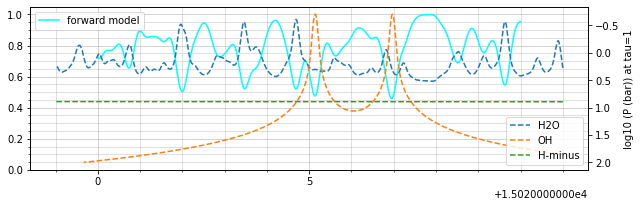

In [7]:
# Plot with tau1plot

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(wavd[::-1], mu, ls='-', color="cyan", label="forward model")
ax.set_ylim(0.0, 1.05)
plt.legend()
plt.grid()

major_xticks = np.arange(round(min(wavd)), round(max(wavd)), 5)
minor_xticks = np.arange(round(min(wavd)), round(max(wavd)), 1)
ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks,minor=True)
plt.grid(which='major', alpha=0.7)
plt.grid(which='minor', alpha=0.5)
plt.minorticks_on()

ax2 = ax.twinx()
ax2.plot(1e8/nus, np.log10(P_tau1_H2O), '--', label="H2O")
ax2.plot(1e8/nus, np.log10(P_tau1_OH), '--', label="OH")
ax2.plot(1e8/nus, np.log10(P_tau1_Hm), '--', label="H-minus")
ax2.set_ylabel('log10 (P (bar)) at tau=1')
plt.legend(loc=4) 
plt.gca().invert_yaxis()
plt.show()